In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp
from sympy.plotting import plot
import operator
from IPython.display import Image
from IPython.core.display import HTML 

In [2]:
def nullcline_intersection(sys, r):
    x, y = sp.symbols('x, y')
    eq1 = sys(x, y, r)[0]
    eq2 = sys(x, y, r)[1]
    sols = sp.solve([eq1, eq2], [x, y])
    return np.array(sols,dtype=float)

def plot_flow(sys, r, x_window, y_window, num_arrows):
    
    linx = np.linspace(x_window[0], x_window[1], num_arrows)
    liny = np.linspace(y_window[0], y_window[1], num_arrows)
    X, Y = np.meshgrid(linx, liny)
    
    Xa = sys(X, Y, r)[0]
    Ya = sys(X, Y, r)[1]
    
    n = np.sqrt(Xa*Xa + Ya*Ya)
    plt.title('Slope Field and Nullcline Intersections');
    plt.quiver(X, Y, Xa/n, Ya/n, color='g');
    

def str_to_func(s):
    return eval(f'lambda x, y : {s}')

In [36]:
def jacsysFC(k,c,r):
    # G1 = dc/dt
    # G2 = dk/dt
    # J = [dG1/dc, dG1/dk
    #      dG2/dc, dG2/dk]
    alpha, delta, xt, n, rho, b, gamma = r[0], r[1], r[2], r[3], r[4], r[5], r[6]
    J = np.array([[alpha*k**(alpha-1)-(delta+xt+n), -1],
    [c*alpha*(alpha-1)*k**(alpha-2), alpha*k**(alpha-1) - (delta+xt) - rho]])
    return J

def dFull(k,c,r):
    alpha, delta, xt, n, rho, b, gamma = r[0], r[1], r[2], r[3], r[4], r[5], r[6]
    G1 = k**alpha - (delta+xt+n)*k - c
    G2 = c*(alpha*k**(alpha-1) - (delta+xt) - rho) # b*exp(-gamma*t) -> 0 as t -> infty
    # returning the array [dK, dC]
    return [G1, G2]

def dNo(k,c,r):
    alpha, delta, xt, n, rho, b, gamma = r[0], r[1], r[2], r[3], r[4], r[5], r[6]
    G1 = k**alpha - (delta+xt+n)*k - c
    G2 = c*(alpha*k**(alpha-1) - (delta+xt) - lam)
    # returning the array [dK, dC]
    return [G1, G2]

def dJ(k,c,r):
    return [r[0]*k+r[1]*c,r[2]*k+r[3]*c]

def jacobian(sys, eq, r):
    x = sp.Symbol('k'); y = sp.Symbol('c')
    x_eq = sys(x, y, r)[0]
    y_eq = sys(x, y, r)[1]
    jac = [ [ sp.Derivative(x_eq, x).doit(), sp.Derivative(x_eq, y).doit() ], 
           [ sp.Derivative(y_eq, x).doit(), sp.Derivative(y_eq, y).doit()]]
    #J = [[str_to_func(jac[0][0].__repr__())(eq[0],eq[1]),str_to_func(jac[0][1].__repr__())(eq[0],eq[1])],
    #    [str_to_func(jac[1][0].__repr__())(eq[0],eq[1]),str_to_func(jac[1][1].__repr__())(eq[0],eq[1])]]
    fnr1 = [ str_to_func(e.__repr__()) for e in jac[0] ]
    fnr2 = [ str_to_func(e.__repr__()) for e in jac[1] ]
    return [fnr1, fnr2]

def print_jacobian(sys,r):
    x = sp.Symbol('k'); y = sp.Symbol('c')
    x_eqn = sys(x, y, r)[0]
    y_eqn = sys(x, y, r)[1]
    jac = [ [ sp.Derivative(x_eqn, x).doit(), sp.Derivative(x_eqn, y).doit() ], 
           [ sp.Derivative(y_eqn, x).doit(), sp.Derivative(y_eqn, y).doit()]]
    print(jac)

In [7]:
print_jacobian(dF,r)

[[0.75*k**(-0.25) - 0.08, -1], [-0.1875*c*k**(-1.25), 0.75*k**(-0.25) - 0.09]]


## RK4 and Linearized System

In [8]:
## using keiths notes on full commitment
def rk4(t,y,h,func,J):
    k1 = h*func(t,y,J)
    k2 = h*func(t+0.5*h,y+0.5*k1,J)
    k3 = h*func(t+0.5*h,y+0.5*k2,J)
    k4 = h*func(t+h,y+k3,J)
    return (k1 + 2*k2 + 2*k3 + k4)/6

# Homebrew Solver: Euler's Method
def rk4_solve(t0,tf,h,y0,func,J):
    tv, yv, = [], []
    t, y = t0, y0
    while t < tf:
        y += rk4(t,y,h,func,J)
        t += h
        yv.append(y.copy())
        tv.append(t)
    return np.array(tv), np.array(yv)

def F(t,U,J):
    # System of Equations
    return np.array([ J[0,0]*U[0] + J[0,1]*U[1],
                      J[1,0]*U[0] + J[1,1]*U[1]])

### No Commitment Case

In [90]:
#alpha, delta, xt, n, rho, b, gamma = 0.75, 0.05, 0.02, 0.01, 0.02, 0.5, 0.5
r = (alpha, delta, xt, n, rho, 0, gamma)

alpha, delta, xt, n = 0.75, 0.05, 0.02, 0.01
rho, b, gamma = 0.02, 0.5, 0.5
lam = .03653

# Equations of k*_0 and c*_0 for No Commitment
kzed = (alpha/(delta + lam + xt))**(1/(1-alpha)) 
czed = kzed**alpha - (delta + n + xt)*kzed 

eq = nullcline_intersection(dNo,r)
c = np.linspace(ca-czed,cb-czed)
k = np.linspace(ka-kzed,kb-kzed)
JNo = jacsysFC(kstar,cstar,r)
JentriesNo = (JNo[0,0],JNo[0,1],JNo[1,0],JNo[1,1])


print("The Jacobian Matrix of the No Committment case:")
print(JNo)
print(" ")
print("The Eigenvalues and Eigenvectors of the No Commmittment Case:")
print(np.linalg.eig(JNo))

The Jacobian Matrix of the No Committment case:
[[-7.88761207e-02 -1.00000000e+00]
 [-3.01199657e-05 -8.88761207e-02]]
 
The Eigenvalues and Eigenvectors of the No Commmittment Case:
(array([-0.07645184, -0.0913004 ]), array([[ 0.99999706,  0.99992283],
       [-0.00242428,  0.01242332]]))


[[ 1.00000000e-02 -1.00000000e+00]
 [-9.00000000e-04 -1.04083409e-17]]


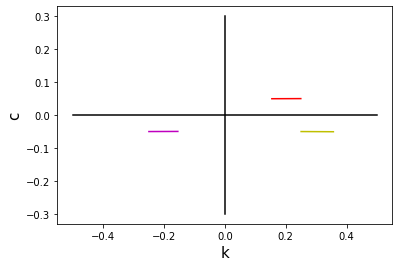

In [38]:
UpLfQ = [-0.005, .005]  # Value in upper left quadrant (Blue)
UpRtQ = [0.01, .005]   # Value in upper right quadrant (Red)
LwLfQ = [-0.01, -0.005] # Value in lower left quadrantn(Purple)
LwRtQ = [0.005, -0.005]  # Value in lower right quadrant (Yellow)

 
JentriesNo = np.array([[JNo[0,0],JNo[0,1]],[JNo[1,0],JNo[1,1]]])
print(JentriesNo)

t,v = rk4_solve(0,2,1e-2, UpLfQ,F,JNo)
t2,v2 = rk4_solve(0,2,1e-2, UpRtQ,F,JNo)
t3,v3 = rk4_solve(0,2,1e-2, LwLfQ,F,JNo)
t4,v4 = rk4_solve(0,2,1e-2, LwRtQ,F,JNo)

#np.shape(v)
plt.plot(v[:,0],v[:,1], 'b',v2[:,0], v2[:,1],'r',v3[:,0], v3[:,1],'m',v4[:,0], v4[:,1],'y',
         [-.5,.50],[0,0],'k',[0,0],[-.30, .30],'k');
plt.xlabel('k',size=15)
plt.ylabel('c',size=15);

### Full Commitment Case

In [88]:
alpha, delta, xt, n, rho, b, gamma = 0.75, 0.05, 0.02, 0.01, 0.02, 0.5, 0.5
r = (alpha, delta, xt, n, rho, 0, gamma)


# Equations of k*_inf and c*_inf for Full Commitment
kinf = (alpha/(delta + rho + xt))**(1/(1-alpha)) 
cinf = kinf**alpha - (delta + n + xt)*kinf 

eq = nullcline_intersection(dFull,r)
c = np.linspace(ca-cinf,cb-cinf)
k = np.linspace(ka-kinf,kb-kinf)
Jinf = jacsysFC(kstar,cstar,r)
Jentries = (Jinf[0,0],Jinf[0,1],Jinf[1,0],Jinf[1,1])

print("The Jacobian Matrix of the Full Committment case:")
print(Jinf)
print(" ")
print("The Eigenvalues and Eigenvectors of the Full Commmittment Case:")
print(np.linalg.eig(Jinf))


The Jacobian Matrix of the Full Committment case:
[[ 1.00000000e-02 -1.00000000e+00]
 [-9.00000000e-04 -1.04083409e-17]]
 
The Eigenvalues and Eigenvectors of the Full Commmittment Case:
(array([ 0.03541381, -0.02541381]), array([[ 0.99967723,  0.99937352],
       [-0.02540561,  0.03539163]]))


[[ 1.e-02 -1.e+00]
 [-9.e-04  0.e+00]]


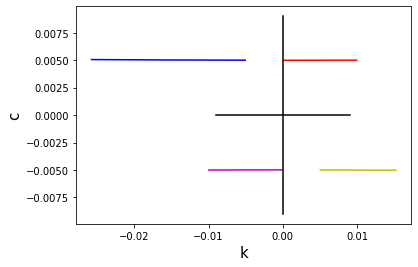

In [66]:
UpLfQ = [-0.005, .005]  # Value in upper left quadrant (Blue)
UpRtQ = [0.01, .005]   # Value in upper right quadrant (Red)
LwLfQ = [-0.01, -0.005] # Value in lower left quadrantn(Purple)
LwRtQ = [0.005, -0.005]  # Value in lower right quadrant (Yellow)


JentriesInf = np.array([[Jinf[0,0],Jinf[0,1]],[Jinf[1,0],Jinf[1,1]]])
JentriesInf = np.array([[Jinf[0,0],-1],[Jinf[1,0],0]])

print(JentriesInf)


t,v = rk4_solve(0,4,1e-2, UpLfQ,F,JentriesInf)
t2,v2 = rk4_solve(0,2,1e-2, UpRtQ,F,JentriesInf)
t3,v3 = rk4_solve(0,2,1e-2, LwLfQ,F,JentriesInf)
t4,v4 = rk4_solve(0,2,1e-2, LwRtQ,F,JentriesInf)

#np.shape(v)
plt.plot(v[:,0],v[:,1], 'b',v2[:,0], v2[:,1],'r',v3[:,0], v3[:,1],'m',v4[:,0], v4[:,1],'y',
         [-.009,.009],[0,0],'k',[0,0],[-.009, .009],'k');

plt.xlabel('k',size=15)
plt.ylabel('c',size=15);

###### The paths around the stable point, siplaying the saddle paths for above the stable point.

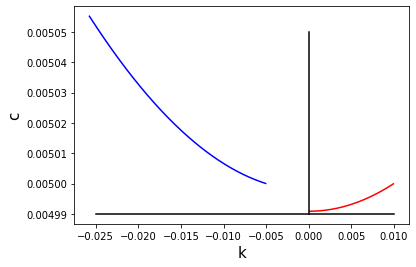

In [81]:
plt.plot(v[:,0],v[:,1], 'b', v2[:,0],v2[:,1], 'r',
         [0,0],[0.00499,.00505], 'black', [-.025, .010], [.00499,.00499], 'black');
plt.xlabel('k',size=15)
plt.ylabel('c',size=15);

###### he paths around the stable point, siplaying the saddle paths for beelow the stable point.

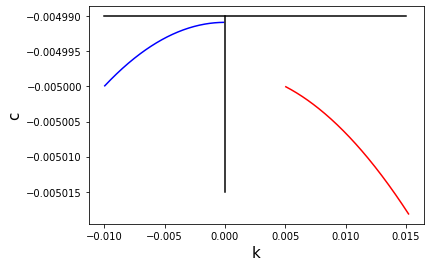

In [86]:
plt.plot(v3[:,0],v3[:,1], 'b', v4[:,0],v4[:,1], 'r',
         [0,0],[-0.00499,-0.005015], 'black', [-.010, .015], [-0.00499,-.00499], 'black');
plt.xlabel('k',size=15)
plt.ylabel('c',size=15);